# TCN Model for Delay Prediction

The TCN uses dilated causal convolutions as an alternative to LSTM recurrence. Uses the same 22 features as LSTM for a fair comparison. TCN has a larger receptive field (29 timesteps) with fewer parameters than LSTM.

In [1]:
# imports
import sys
import os
sys.path.append(os.path.abspath(".."))

import random
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

from src.models.tcn import FlightDelayTCN, TCNTrainer
from src.models.lstm import FlightDelayLSTM
from src.evaluation.metrics import calculate_delay_metrics
from src.config import TRAIN_END, VAL_END, TEST_START
from src.config import SEQUENCE_MODEL_FEATURES

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

TARGET_COL = 'avg_arr_delay'
device = torch.device('mps')
print(f'Using device: {device}')

Importing plotly failed. Interactive plots will not work.


Using device: mps


## Load and Prepare Data

In [2]:
# load feature data
df = pd.read_csv('../data/processed/features.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['route', 'date']).reset_index(drop=True)

available_features = [c for c in SEQUENCE_MODEL_FEATURES if c in df.columns]
print(f'Using {len(available_features)} features for TCN (minimal time-native set)')
print(f'Features: {available_features}')

Using 22 features for TCN (minimal time-native set)
Features: ['avg_arr_delay', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'is_weekend', 'is_federal_holiday', 'is_holiday_week', 'is_school_break', 'is_covid_period', 'is_covid_recovery', 'is_post_covid', 'weather_severity_max', 'apt1_severity', 'apt2_severity', 'has_adverse_weather', 'apt1_temp_avg', 'apt2_temp_avg', 'total_precip', 'total_snowfall', 'max_wind', 'severe_weather_level']


## Create Data Loaders

In [3]:
# create train/val/test splits and data loaders
config = {
    'sequence_length': 28,
    'batch_size': 32,
    'num_channels': [32, 64, 64],
    'kernel_size': 3,
    'dropout': 0.2,
    'learning_rate': 0.001,
    'epochs': 50,
}

train_df = df[df['date'] < TRAIN_END].copy()
val_df = df[(df['date'] >= TRAIN_END) & (df['date'] < VAL_END)].copy()
test_df = df[df['date'] >= TEST_START].copy()

print(f'Train: {len(train_df):,} ({train_df["date"].min().date()} to {train_df["date"].max().date()})')
print(f'Val:   {len(val_df):,} ({val_df["date"].min().date()} to {val_df["date"].max().date()})')
print(f'Test:  {len(test_df):,} ({test_df["date"].min().date()} to {test_df["date"].max().date()})')

scaler = StandardScaler()
scaler.fit(train_df[available_features].values)

def create_route_sequences(route_df, scaler, feature_cols, target_col, seq_len):
    """Create sequences per route for proper time series handling."""
    all_X, all_y = [], []
    for route in route_df['route'].unique():
        rdf = route_df[route_df['route'] == route].sort_values('date')
        features = scaler.transform(rdf[feature_cols].values)
        targets = rdf[target_col].values
        for i in range(seq_len, len(rdf)):
            all_X.append(features[i-seq_len:i])
            all_y.append(targets[i])
    return np.array(all_X), np.array(all_y)

train_X, train_y = create_route_sequences(train_df, scaler, available_features, TARGET_COL, config['sequence_length'])
val_X, val_y = create_route_sequences(val_df, scaler, available_features, TARGET_COL, config['sequence_length'])
test_X, test_y = create_route_sequences(test_df, scaler, available_features, TARGET_COL, config['sequence_length'])

print(f'\nSequences: Train={len(train_X):,}, Val={len(val_X):,}, Test={len(test_X):,}')

train_dataset = TensorDataset(torch.tensor(train_X, dtype=torch.float32), torch.tensor(train_y, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(val_X, dtype=torch.float32), torch.tensor(val_y, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(test_X, dtype=torch.float32), torch.tensor(test_y, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'])

print(f'Batches: Train={len(train_loader)}, Val={len(val_loader)}, Test={len(test_loader)}')

Train: 36,520 (2019-01-01 to 2023-12-31)
Val:   3,640 (2024-01-01 to 2024-06-30)
Test:  7,300 (2024-07-01 to 2025-06-30)

Sequences: Train=35,960, Val=3,080, Test=6,740
Batches: Train=1124, Val=97, Test=211


## Load Trained Model

Model is trained via `src/training/train_tcn.py` and saved to `trained_models/`. Loading the checkpoint here for evaluation and comparison.

In [4]:
# load trained TCN from checkpoint
checkpoint = torch.load('../trained_models/best_tcn_arr_delay.pt', map_location=device, weights_only=False)

model = FlightDelayTCN(
    input_size=checkpoint.get('input_size', len(available_features)),
    num_channels=checkpoint.get('num_channels', config['num_channels']),
    kernel_size=checkpoint.get('kernel_size', config['kernel_size']),
    dropout=checkpoint.get('dropout', config['dropout'])
)
model.load_state_dict(checkpoint['model_state_dict'])

trainer = TCNTrainer(model, learning_rate=config['learning_rate'], device=device)
history = checkpoint['history']

print(f'Receptive field: {model.receptive_field} time steps')
total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params:,}')
print(f'Trained for {len(history["train_loss"])} epochs')

Receptive field: 29 time steps
Total parameters: 54,113
Trained for 25 epochs


## Training Curves

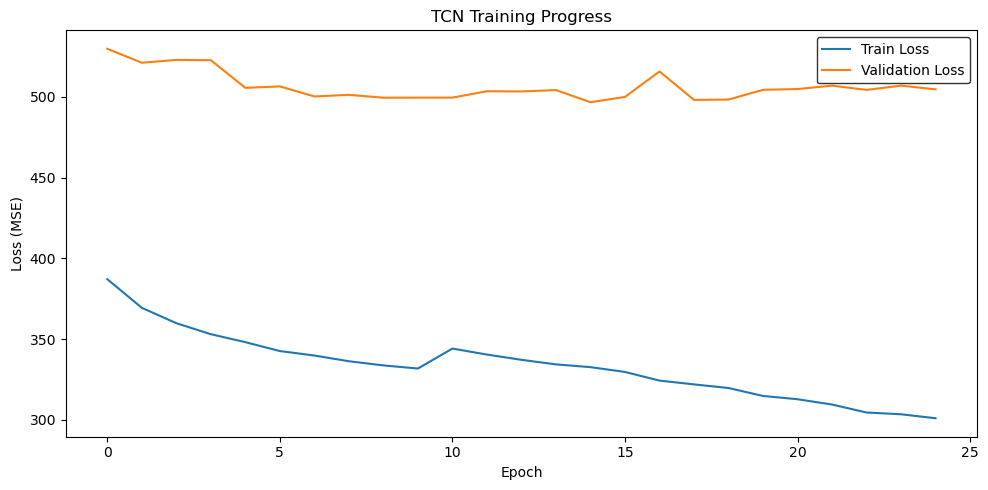

In [5]:
# plot training and validation loss curves
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(history['train_loss'], label='Train Loss')
ax.plot(history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (MSE)')
ax.set_title('TCN Training Progress')
ax.legend(frameon=True, edgecolor='black')

plt.tight_layout()
plt.show()

## Evaluate on Test Set

In [6]:
# evaluate model on test set
predictions = trainer.predict(test_loader)

test_targets = []
for _, y in test_loader:
    test_targets.extend(y.numpy())
test_targets = np.array(test_targets)

metrics = calculate_delay_metrics(test_targets, predictions)

print('\nTest Set Metrics (Delay Prediction):')
print(f'  MAE:              {metrics["mae"]:.2f} min')
print(f'  RMSE:             {metrics["rmse"]:.2f} min')
print(f'  Within 15min:     {metrics["within_15"]:.1f}%')
print(f'  Directional Acc:  {metrics["directional"]:.1f}%')
print(f'  R²:               {metrics["r2"]:.3f}')


Test Set Metrics (Delay Prediction):
  MAE:              13.63 min
  RMSE:             21.69 min
  Within 15min:     70.1%
  Directional Acc:  78.0%
  R²:               0.168


## Full Model Comparison

Comparison of all four models on the same test set.

In [7]:
import joblib

# LSTM comparison
lstm_path = '../trained_models/best_lstm_arr_delay.pt'
checkpoint = torch.load(lstm_path, map_location=device, weights_only=False)

lstm_model = FlightDelayLSTM(
    input_size=checkpoint.get('input_size', len(available_features)),
    hidden_size=checkpoint.get('hidden_size', 64),
    num_layers=checkpoint.get('num_layers', 2),
    dropout=checkpoint.get('dropout', 0.3)
)
lstm_model.load_state_dict(checkpoint['model_state_dict'])
lstm_model.to(device)
lstm_model.eval()

lstm_predictions = []
with torch.no_grad():
    for x_batch, _ in test_loader:
        x_batch = x_batch.to(device)
        preds = lstm_model(x_batch)
        lstm_predictions.extend(preds.cpu().numpy())
lstm_predictions = np.array(lstm_predictions)
lstm_metrics = calculate_delay_metrics(test_targets, lstm_predictions)

# tree-based models on the same test period
from src.config import TABULAR_FEATURES

tabular_features = [c for c in TABULAR_FEATURES if c in df.columns]
target_col = 'avg_arr_delay'

tree_test_df = df[df['date'] >= TEST_START].dropna(subset=tabular_features + [target_col])
y_tree_test = tree_test_df[target_col].values

# pass DataFrames (not .values) so sklearn doesn't warn about missing feature names
xgb_model = joblib.load('../trained_models/xgboost_delay.pkl')
xgb_preds = xgb_model.predict(tree_test_df[tabular_features])
xgb_metrics = calculate_delay_metrics(y_tree_test, xgb_preds)

lgb_model = joblib.load('../trained_models/lightgbm_delay.pkl')
lgb_preds = lgb_model.predict(tree_test_df[tabular_features])
lgb_metrics = calculate_delay_metrics(y_tree_test, lgb_preds)

comparison = pd.DataFrame([
    {'Model': 'XGBoost (57 features)', 'MAE (min)': xgb_metrics['mae'], 'RMSE (min)': xgb_metrics['rmse'], 'Within 15min': xgb_metrics['within_15'], 'R²': xgb_metrics['r2']},
    {'Model': 'LightGBM (57 features)', 'MAE (min)': lgb_metrics['mae'], 'RMSE (min)': lgb_metrics['rmse'], 'Within 15min': lgb_metrics['within_15'], 'R²': lgb_metrics['r2']},
    {'Model': 'TCN (22 features)', 'MAE (min)': metrics['mae'], 'RMSE (min)': metrics['rmse'], 'Within 15min': metrics['within_15'], 'R²': metrics['r2']},
    {'Model': 'LSTM (22 features)', 'MAE (min)': lstm_metrics['mae'], 'RMSE (min)': lstm_metrics['rmse'], 'Within 15min': lstm_metrics['within_15'], 'R²': lstm_metrics['r2']},
]).set_index('Model').round(2)

print('Full Model Comparison on Test Set (2024-07-01 to 2025-06-30):')
comparison

Full Model Comparison on Test Set (2024-07-01 to 2025-06-30):


,MAE (min),RMSE (min),Within 15min,R²
Model,,,,
XGBoost (57 features),11.79,19.64,77.19,0.36
LightGBM (57 features),11.78,19.75,77.25,0.36
TCN (22 features),13.63,21.69,70.15,0.17
LSTM (22 features),13.96,22.52,70.37,0.10


## Receptive Field Analysis

In [8]:
# print architecture analysis
print('TCN Architecture Analysis:')
print(f'  Input sequence length: {config["sequence_length"]} days')
print(f'  Receptive field: {model.receptive_field} time steps')
print(f'  Channel progression: {config["num_channels"]}')
print(f'  Kernel size: {config["kernel_size"]}')
print(f'  Dilation factors: {[2**i for i in range(len(config["num_channels"]))]}')

TCN Architecture Analysis:
  Input sequence length: 28 days
  Receptive field: 29 time steps
  Channel progression: [32, 64, 64]
  Kernel size: 3
  Dilation factors: [1, 2, 4]


## Summary

TCN and LSTM land in a similar range, with TCN having a slight edge (13.63 vs 13.96 min MAE). That 2.3% difference could easily flip with different hyperparameters or a different random seed though. The LSTM uses dropout 0.3 vs TCN's 0.2, and each architecture has its own capacity knobs (hidden size and num layers for LSTM, channel widths and kernel size for TCN), so you would need a proper hyperparameter search across both to say anything definitive.

Either way, both deep learning models are well behind XGBoost (11.79) and LightGBM (11.78). On this tabular dataset with engineered features, gradient boosting wins clearly.

**Next:** [08_error_analysis.ipynb](08_error_analysis.ipynb)